In [4]:
%matplotlib inline
from __future__ import print_function

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2
 
from utils.nolearn_net import NeuralNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data 

In [6]:
microclimate_train = pd.read_csv('data/eaa4fe4a-b85f-4088-85ee-42cabad25c81.csv',
                                 index_col=0, parse_dates=[0])

microclimate_test = pd.read_csv('data/fb38df29-e4b7-4331-862c-869fac984cfa.csv',
                                index_col=0, parse_dates=[0])

macroclimate_guelmim = pd.read_csv('data/41d4a6af-93df-48ab-b235-fd69c8e5dab9.csv',
                                 index_col = 0, parse_dates= [0])
macroclimate_sidi = pd.read_csv('data/b57b4f6f-8aae-4630-9a14-2d24902ddf30.csv',
                                 index_col = 0, parse_dates= [0])
macroclimate_agadir = pd.read_csv('data/e384729e-3b9e-4f53-af1b-8f5449c69cb7.csv',
                                 index_col = 0, parse_dates= [0])


labels = pd.read_csv('data/a0f785bc-e8c7-4253-8e8a-8a1cd0441f73.csv',
                     index_col=0, parse_dates=[0])

submission_format = pd.read_csv('data/submission_format.csv',
                                index_col=0, parse_dates=[0])

# Preprocessing 

The training set consist of measurements every 2 hours on the station.
While the lag between most of measurements is 2h, some of them show a larger time difference.
We first use that to define some group in the training set.

In [7]:
def add_group_column_to_data(df):
    ''' Get a dataframe, and return the same DF with an extra
    columns group which reference different group. The split is 
    realized on time where the lag jump from 2H to more !'''
    
    # Get the time difference between obs
    timedelta = [df.index[i+1]-df.index[i] for i in range(len(df)-1)]
    # Get the idx where the time difference is larger than only 2H
    cut = list(np.where(np.array(map(lambda x:x.components.days, timedelta)) !=0)[0])
    # Put that in a dict with groups
    dict_cut = {cut[k]:'group'+str(k) for k in range(len(cut))}
    def idx_group(idx):
        ''' from the idx in the df, return the corresponding group '''
        try:
            mask = np.where((np.array(cut)-idx)>=0)[0]
            group_key = np.array(cut)[mask].min()
            return dict_cut[group_key]
        except:
            return 'group'+str(len(cut))
    
    df['group']= map(idx_group,range(len(df)))
    return df


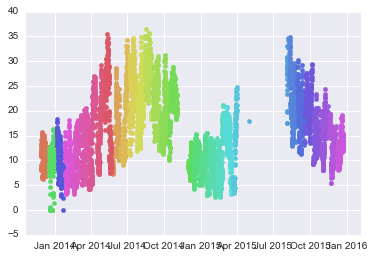

In [8]:
df_train =  add_group_column_to_data(microclimate_train)
i= 0
for key,gp in df_train.groupby('group'):
    plt.scatter(gp.index,gp.temp,color = sns.color_palette('hls',len(df_train.groupby('group')))[i])
    i+=1

In [73]:
train.columns.tolist()[:-2]

['percip_mm',
 'humidity',
 'temp',
 'leafwet450_min',
 'leafwet460_min',
 'leafwet_lwscnt',
 'gusts_ms',
 'wind_dir',
 'wind_ms']

## Train/Val/Test split

We are going to split that thing in three different group train/val/test

- I take the 20 first group for training
- I take the 7 that follows for validation
- I take the 8 remaining for testing

In [9]:
group_train = ['group'+str(i) for i in range(20)]
group_train.remove('group0') # I remove it as there is only Nan in that group
train = df_train[df_train.group.isin(group_train)]
train_y = labels[labels.index.isin(train.index)]
train = train.join(train_y)
gtrain = train.groupby('group')
print('Le train is composed by %d group and %d observation'%(gtrain.ngroups,len(train)))

group_val = ['group'+str(i) for i in range(20,27)]
val = df_train[df_train.group.isin(group_val)]
val_y = labels[labels.index.isin(val.index)]
val = val.join(val_y)
gval = val.groupby('group')
print('Le val is composed by %d group and %d observation'%(gval.ngroups,len(val)))

group_test = ['group'+str(i) for i in range(27,27+8)]
test = df_train[df_train.group.isin(group_test)]
test_y = labels[labels.index.isin(test.index)]
gtest = test.groupby('group')
print('Le test is composed by %d group and %d observation'%(gtest.ngroups,len(test)))

Le train is composed by 19 group and 3354 observation
Le val is composed by 7 group and 1083 observation
Le test is composed by 8 group and 1361 observation


## Processing to feed the data to a RNN 

In [10]:
class BaseBatchIterator(object):
    
    '''
    Class to proceed from the dataframe to batch of data to be
    feed in the rnn
    
    '''
    def __init__(self, feats = [], label = 'yield',batch_size = 25, size_seq = 25, stride = 1, verbose=False):
        # feature to take from the dataframe
        self.feats = feats
        # Target 
        self.labels = label
        # Size of the sequence you want to enroll in the rnn
        self.seq_size = size_seq
        # Stride for the construction of the sequence. 
        # For instance, if we have [xa,xb,xc,xd,xe,xf] where each x is a D-dimensional vector.
        # A stride of 2 with a size_seq of 4, willr etuyrn [[xa,xb,xc,xd],[xc,xd,xe,xf]] 
        # Looks like a conv 1D !
        self.stride = stride
        # Size of the batch to process each step of the gradient update
        self.batch_size = batch_size
        self.verbose = False

    def __call__(self, df):
        self.df = df
        self.stack_seqs =  self.stack_sequence()
        return self

    def stack_sequence(self):
        ''' 
        This function allows to take the training dataframe, and 
        return a dict of (X,y) tupple. Each key correspond to a 
        different group - define above. Each group is consituted by a 
        continuous sequence of observation (2H lags). 
        For each group, we input a dataframe of size (N,D). N obs/ D features.
        We then build sequence of observation from it. A trivial 
        way to do it is to take df.iloc[0:seq_size],df.iloc[seq_size:2seq_size]
        and so on. 
        
        However, we proceed as for a 1D convolution. For instance, 
        if we have [xa,xb,xc,xd,xe,xf] where each x is a D-dimensional vector.
        The X, for a stride of 2 with a size_seq of 4, should be [[xa,xb,xc,xd],[xc,xd,xe,xf]].
        The number of sequence is given by the simple formula 
        n_sequences = (N-seq_size)/stride +1
        
        '''
        # The input dataframe is basically (N,D) dimensional tensor.
        # N is the number of obs
        # D is the number of feature to consider !
        
        gps = self.df.groupby('group') # Get the groups of continuous obs from the df
        n_groups = gps.ngroups #Nb groups, define by timelag between obs
        stack_seqs = dict.fromkeys(set(self.df.group)) # Initialize a dict to store (X,y)
        for key,gp in gps:
            nb_obs = gp.shape[0] # Nb of obs in the group
            # Nb of sequences
            nb_seqs = (nb_obs-self.seq_size)/self.stride +1
            
            # Begin of the processing
            for k in range(nb_seqs):
                kmin = k*self.stride # lower bound window
                kmax = k*self.stride+self.seq_size # Upper boud window
                X_tmp = np.array(gp[self.feats].iloc[kmin:kmax])[np.newaxis,:] # Get the X
                y_tmp = np.array(gp[self.labels].iloc[kmin:kmax])[np.newaxis,:] # Get the y
                if k == 0:
                    X = X_tmp
                    y = y_tmp
                else:
                    X = np.vstack((X,X_tmp)) # Stack them
                    y = np.vstack((y,y_tmp)) # Stack them
            # At the end, X has a shape (N,T,D)
            # y has a shape (N,T)
            stack_seqs[key] = (X,y)
        return stack_seqs
        
        
    def __iter__(self):
        # Iterator
        n_groups = len(self.stack_seqs.keys()) #Nb groups
        for gp,(X,y) in self.stack_seqs.iteritems():
            n_samples = X.shape[0]
            bs = self.batch_size
            n_batches = (n_samples + bs - 1) // bs
            idx = range(len(X))
            for i in range(n_batches):
                sl = slice(i * bs, (i + 1) * bs)
                Xb = X[idx[sl]]
                yb = y[idx[sl]]
                yield self.transform(Xb, yb)

    @property
    def n_samples(self):
        X = self.X
        if isinstance(X, dict):
            return len(list(X.values())[0])
        else:
            return len(X)

    def transform(self, Xb, yb):
        return Xb, yb

    def __getstate__(self):
        state = dict(self.__dict__)
        for attr in ('X', 'y',):
            if attr in state:
                del state[attr]
        return state


In [74]:
batch_iterator = BaseBatchIterator(train.columns.tolist()[:-2],'yield',batch_size= 3,stride=2)
batch_iterator_train = batch_iterator(train)
batch_iterator_test = batch_iterator(val)

In [75]:
for i,(X,y) in enumerate(batch_iterator_train):
    print(X.shape,y.shape)
    if i ==5:
        sys.exit()

(3, 25, 9) (3, 25)
(3, 25, 9) (3, 25)
(3, 25, 9) (3, 25)
(3, 25, 9) (3, 25)
(3, 25, 9) (3, 25)
(3, 25, 9) (3, 25)


SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


# RNN MODEL 

In [13]:
from __future__ import print_function

import numpy as np
import theano
import theano.tensor as T
import lasagne

# Lasagne Seed for Reproducibility
lasagne.random.set_rng(np.random.RandomState(1))

In [76]:
import theano.tensor as TT 
## Parameters
# batch size : N
# Seq length : T
# Num features : D
# Size hidden layer

D = 9
H = 100
GRAD_CLIP = 10
# First, we build the network, starting with an input layer
# Recurrent layers expect input of shape
# (batch size, SEQ_LENGTH, num_features)

l_in = lasagne.layers.InputLayer(name='in', 
                                 shape=(None, None, D))
batchsize, seqlen, _ = l_in.input_var.shape

# We now build the LSTM layer which takes l_in as the input layer
# We clip the gradients at GRAD_CLIP to prevent the problem of exploding
# gradients.

l_lstm = lasagne.layers.LSTMLayer(l_in, 
                                     H,
                                     name='lstm',
                                     grad_clipping=GRAD_CLIP,
                                     nonlinearity=lasagne.nonlinearities.tanh)
l_shp = lasagne.layers.ReshapeLayer(l_lstm, (-1, H))
l_dense = lasagne.layers.DenseLayer(l_shp, 
                                    num_units=1,
                                   name = 'dense',
                                   nonlinearity = lasagne.nonlinearities.identity)
l_out = lasagne.layers.ReshapeLayer(l_dense, (batchsize, seqlen))
network_output = lasagne.layers.get_output(l_out)

target_values = TT.fmatrix('target_output')
loss = lasagne.objectives.squared_error(network_output,target_values).mean()

# Retrieve all parameters from the network
all_params = lasagne.layers.get_all_params(l_out, trainable=True)

# Compute AdaGrad updates for training
print("Computing updates ...")
updates = lasagne.updates.adam(loss, all_params, 0.001)

# Theano functions for training and computing cost
print("Compiling functions ...")
#train = theano.function([l_in.input_var, target_values],
#                        loss, 
#                        updates=updates, 
#                        allow_input_downcast=True)


Computing updates ...
Compiling functions ...


In [ ]:
from utils.nolearn_net import NeuralNet
net = NeuralNet(
    layers=l_out,
    regression=True,
    objective_loss_function=lasagne.objectives.squared_error,
    objective_l2=1e-7,
    update=lasagne.updates.adam,
    update_learning_rate=1e-4,
    train_split = False,
    batch_iterator_train=batch_iterator_train,
    batch_iterator_test=batch_iterator_test,
    verbose=10,
    max_epochs=1000,
)

net.fit(epochs = 200)

# Neural Network with 44401 learnable parameters

## Layer information

  #  name    size
---  ------  --------
  0  in      Nonex9
     lstm    Nonex100
             100
     dense   1
             None

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1           nan           nan          nan  2.69s
      2           nan           nan          nan  2.73s
      3           nan           nan          nan  2.68s
      4           nan           nan          nan  2.78s
      5           nan           nan          nan  2.72s
      6           nan           nan          nan  2.73s
      7           nan           nan          nan  2.70s
      8           nan           nan          nan  2.72s
      9           nan           nan          nan  2.70s
     10           nan           nan          nan  2.72s
     11           nan           nan          nan  2.70s
     12           nan           nan          nan  2.70s
     13      

In [67]:
net.score()

4.498038945492906

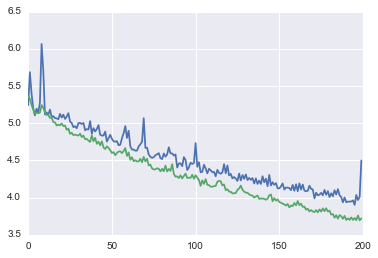

In [69]:
plt.plot([f['valid_loss'] for f in net.train_history_])
plt.plot([f['train_loss'] for f in net.train_history_])

In [2]:
import numpy as np
np.sqrt(3.8)

1.9493588689617927

In [61]:
net.train_history_

[{'dur': 3.287400007247925,
  'epoch': 1,
  'train_loss': 7.7683975445080211,
  'train_loss_best': True,
  'valid_accuracy': 7.6998896763650162,
  'valid_loss': 7.6998896763650162,
  'valid_loss_best': True},
 {'dur': 3.1998419761657715,
  'epoch': 2,
  'train_loss': 7.6097663463102974,
  'train_loss_best': True,
  'valid_accuracy': 7.5734238638084541,
  'valid_loss': 7.5734238638084541,
  'valid_loss_best': True},
 {'dur': 3.0539700984954834,
  'epoch': 3,
  'train_loss': 7.5418800853061994,
  'train_loss_best': True,
  'valid_accuracy': 7.6592661842150918,
  'valid_loss': 7.6592661842150918,
  'valid_loss_best': False},
 {'dur': 3.0253560543060303,
  'epoch': 4,
  'train_loss': 7.5361089977026454,
  'train_loss_best': True,
  'valid_accuracy': 7.5964286321373864,
  'valid_loss': 7.5964286321373864,
  'valid_loss_best': False},
 {'dur': 3.1069140434265137,
  'epoch': 5,
  'train_loss': 7.4843165557526232,
  'train_loss_best': True,
  'valid_accuracy': 7.6243180884216981,
  'valid_loss

In [45]:
net.y_tensor_type

TensorType(float64, matrix)

In [36]:
for Xb,yb in batch_iterator_train:
    print(Xb.shape,yb.shape)
    net.apply_batch_func(net.train_iter_, Xb, yb)
    sys.exit()

(3, 25, 2) (3, 25)


ValueError: Input dimension mis-match. (input[0].shape[1] = 25, input[1].shape[1] = 3)
Apply node that caused the error: Elemwise{sub,no_inplace}(Reshape{3}.0, InplaceDimShuffle{x,0,1}.0)
Toposort index: 252
Inputs types: [TensorType(float64, (False, False, True)), TensorType(float64, (True, False, False))]
Inputs shapes: [(3, 25, 1), (1, 3, 25)]
Inputs strides: [(200, 8, 8), (600, 200, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{sqr,no_inplace}(Elemwise{sub,no_inplace}.0), Elemwise{Composite{((i0 * i1) / i2)}}[(0, 1)](TensorConstant{(1, 1, 1) of 2.0}, Elemwise{sub,no_inplace}.0, Elemwise{mul,no_inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/thorey/miniconda2/envs/fognet/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3012, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/thorey/miniconda2/envs/fognet/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-72393b6b384d>", line 1, in <module>
    net.fit(epochs=1)
  File "utils/nolearn_net.py", line 14, in fit
    self.initialize()
  File "/Users/thorey/miniconda2/envs/fognet/lib/python2.7/site-packages/nolearn/lasagne/base.py", line 359, in initialize
    self.y_tensor_type,
  File "/Users/thorey/miniconda2/envs/fognet/lib/python2.7/site-packages/nolearn/lasagne/base.py", line 466, in _create_iter_funcs
    layers, target=y_batch, **objective_kw)
  File "/Users/thorey/miniconda2/envs/fognet/lib/python2.7/site-packages/nolearn/lasagne/base.py", line 166, in objective
    loss = aggregate(loss_function(network_output, target))
  File "/Users/thorey/miniconda2/envs/fognet/lib/python2.7/site-packages/lasagne/objectives.py", line 169, in squared_error
    return (a - b)**2

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [29]:
Xb.shape,yb.shape

((3, 25, 2), (3, 25))